In [85]:
import pandas as pd
import numpy as np

#

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#

import seaborn as sns
import plotly.express as px

#

import os
import random
import re
import math
import time

from tqdm import tqdm
from tqdm.keras import TqdmCallback


from pandas_summary import DataFrameSummary

import warnings
import missforest

warnings.filterwarnings('ignore') 

In [86]:
seed_val = 47
random.seed(seed_val)
np.random.seed(seed_val)
# Setting color palette.
orange_black = [
    '#fdc029', '#df861d', '#FF6347', '#aa3d01', '#a30e15', '#800000', '#171820'
]

# Setting plot styling.
plt.style.use('ggplot')

In [104]:
df = pd.read_csv('full_data.csv')
df = df[df['duplicated'] == False]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62360 entries, 591 to 62950
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    62360 non-null  int64  
 1   image_id      62360 non-null  object 
 2   diagnosis     62360 non-null  object 
 3   age           62360 non-null  float64
 4   sex           62360 non-null  object 
 5   localization  62360 non-null  object 
 6   source        62360 non-null  object 
 7   severity      62360 non-null  object 
 8   path          62360 non-null  object 
 9   class         62360 non-null  object 
 10  duplicated    62360 non-null  bool   
 11  dataset       62360 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 5.8+ MB


In [105]:
df2=df.replace('unknown',np.NaN).replace(0.0, np.NaN).drop(['Unnamed: 0', 'duplicated', 'source', 'dataset','image_id'], axis=1)
df2['diagnosis'].fillna('unknown', inplace=True)
df2.sample(5)

,diagnosis,age,sex,localization,severity,path,class
26178,unknown,30.0,female,upper extremity,benign,./Data/ISIC_2020/Data/ISIC_4761813.jpg,Unclassified
45066,seborrheic keratoses and other benign tumors,NaN,NaN,NaN,NaN,./Data/dermnet/test/Seborrheic Keratoses and o...,Benign Marking or Mole
48221,herpes hpv and other stds photos,NaN,NaN,NaN,NaN,./Data/dermnet/test/Herpes HPV and other STDs ...,"Toxin, Fungal, Bug, Viral, or Bacterial Infect..."
591,benign keratosis-like lesions,80.0,male,scalp,NaN,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,Benign Marking or Mole
23108,nevus,45.0,male,lower extremity,benign,./Data/ISIC_2020/Data/ISIC_3849358.jpg,Benign Marking or Mole


In [106]:
train = df2.sample(frac=0.9, random_state=47)
test = df2.drop(train.index)
train.shape

(56124, 7)

Text(0.5, 1.0, 'Test Data Missing Values')

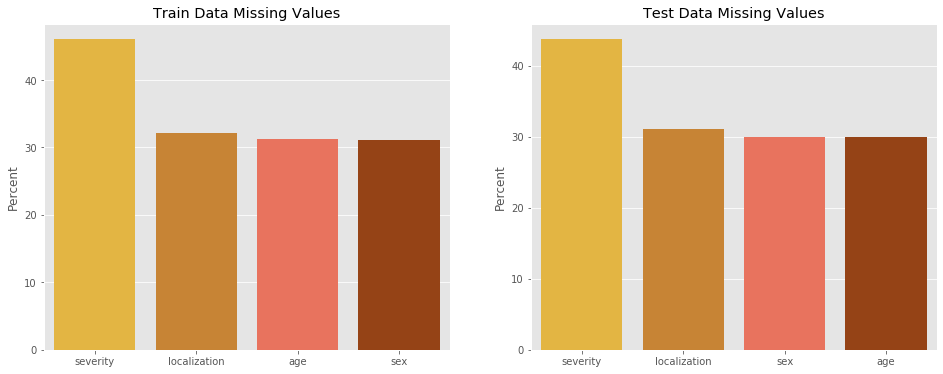

In [107]:
# Checking missing values:

def missing_percentage(df):

    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


missing_train = missing_percentage(train)
missing_test = missing_percentage(test)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=missing_train.index,
            y='Percent',
            data=missing_train,
            palette=orange_black,
            ax=ax[0])

sns.barplot(x=missing_test.index,
            y='Percent',
            data=missing_test,
            palette=orange_black,
            ax=ax[1])

ax[0].set_title('Train Data Missing Values')
ax[1].set_title('Test Data Missing Values')

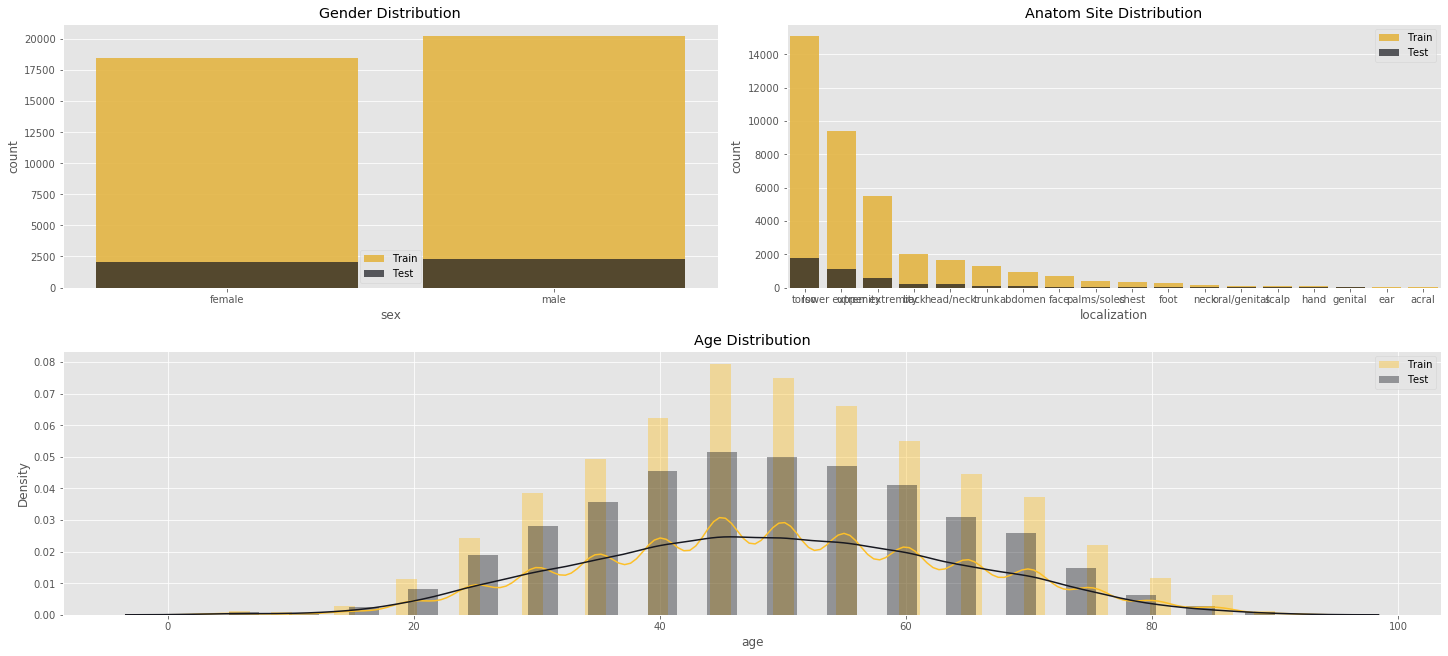

In [108]:
fig = plt.figure(constrained_layout=True, figsize=(20, 9))

# Creating a grid:

grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('Gender Distribution')

sns.countplot(train.sex.sort_values(ignore_index=True),
              alpha=0.9,
              ax=ax1,
              color='#fdc029',
              label='Train')
sns.countplot(test.sex.sort_values(ignore_index=True),
              alpha=0.7,
              ax=ax1,
              color='#171820',
              label='Test')
ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[0, 2:])

# Plot the countplot.

sns.countplot(train.localization,
              alpha=0.9,
              ax=ax2,
              color='#fdc029',
              label='Train',
              order=train['localization'].value_counts().index)
sns.countplot(test.localization,
              alpha=0.7,
              ax=ax2,
              color='#171820',
              label='Test',
              order=test['localization'].value_counts().index), ax2.set_title(
                  'Anatom Site Distribution')

ax2.legend()

# Customizing the third grid.

ax3 = fig.add_subplot(grid[1, :])

# Set the title.

ax3.set_title('Age Distribution')

# Plot the histogram.

sns.distplot(train.age, ax=ax3, label='Train', color='#fdc029')
sns.distplot(test.age, ax=ax3, label='Test', color='#171820')

ax3.legend()

plt.show()

In [109]:
# Filling missing anatom site values with 'unknown' tag:
# Filling missing sex values with 'unknown' tag:
# Filling missing severity values with 'unknown' tag:

for df in [train, test]:
    df['localization'].fillna('unknown', inplace=True)
    df['severity'].fillna('unknown', inplace=True)
    df['sex'].fillna('unknown', inplace=True)

In [110]:
# Double checking:

ids_train = train.localization.values
ids_test = test.localization.values
ids_train_set = set(ids_train)
ids_test_set = set(ids_test)

location_not_overlap = list(ids_train_set.symmetric_difference(ids_test_set))
n_overlap = len(location_not_overlap)
if n_overlap == 0:
    print(
        f'There are no different body parts occuring between train and test set...'
    )
else:
    print('There are some not overlapping values between train and test set!')

There are no different body parts occuring between train and test set...


In [111]:
# Filling age and sex with appropriate values.

## train['sex'].fillna(train['sex'].mode()[0], inplace=True)

train['age'].fillna(train['age'].median(), inplace=True)

In [112]:
print(
    f'Train missing value count: {train.isnull().sum().sum()}\nTest missing value count: {train.isnull().sum().sum()}'
)

Train missing value count: 0
Test missing value count: 0


In [113]:
# Train data:

cntstr = train.localization.value_counts().rename_axis('localization').reset_index(
    name='count')

fig = px.treemap(cntstr,
                 path=['localization'],
                 values='count',
                 color='count',
                 color_continuous_scale=orange_black,
                 title='Scans by Anatom Site General Challenge - Train Data')

fig.update_traces(textinfo='label+percent entry')
fig.show()

In [114]:
# Plotting interactive sunburst:

fig = px.sunburst(data_frame=train,
                  path=['class', 'sex', 'localization'],
                  color='sex',
                  color_discrete_sequence=orange_black,
                  maxdepth=-1,
                  title='Sunburst Chart Class > Sex > Localization')

fig.update_traces(textinfo='label+percent parent')
fig.update_layout(margin=dict(t=0, l=0, r=0, b=0))
fig.show()